### **1. Data Preparation**
Load the data stored in Google Drive. Skip this section if you already have a local path towards the dataset.

In [ ]:
!mkdir '/content/data'
!unzip "/content/drive/My Drive/COMP9517 20T2 Group Project Image Sequences.zip" -d '/content/data'

### **2. Data Preprocessing**
Aiming to generate high-accuracy segmentation to facilitate the process of finding contours later.

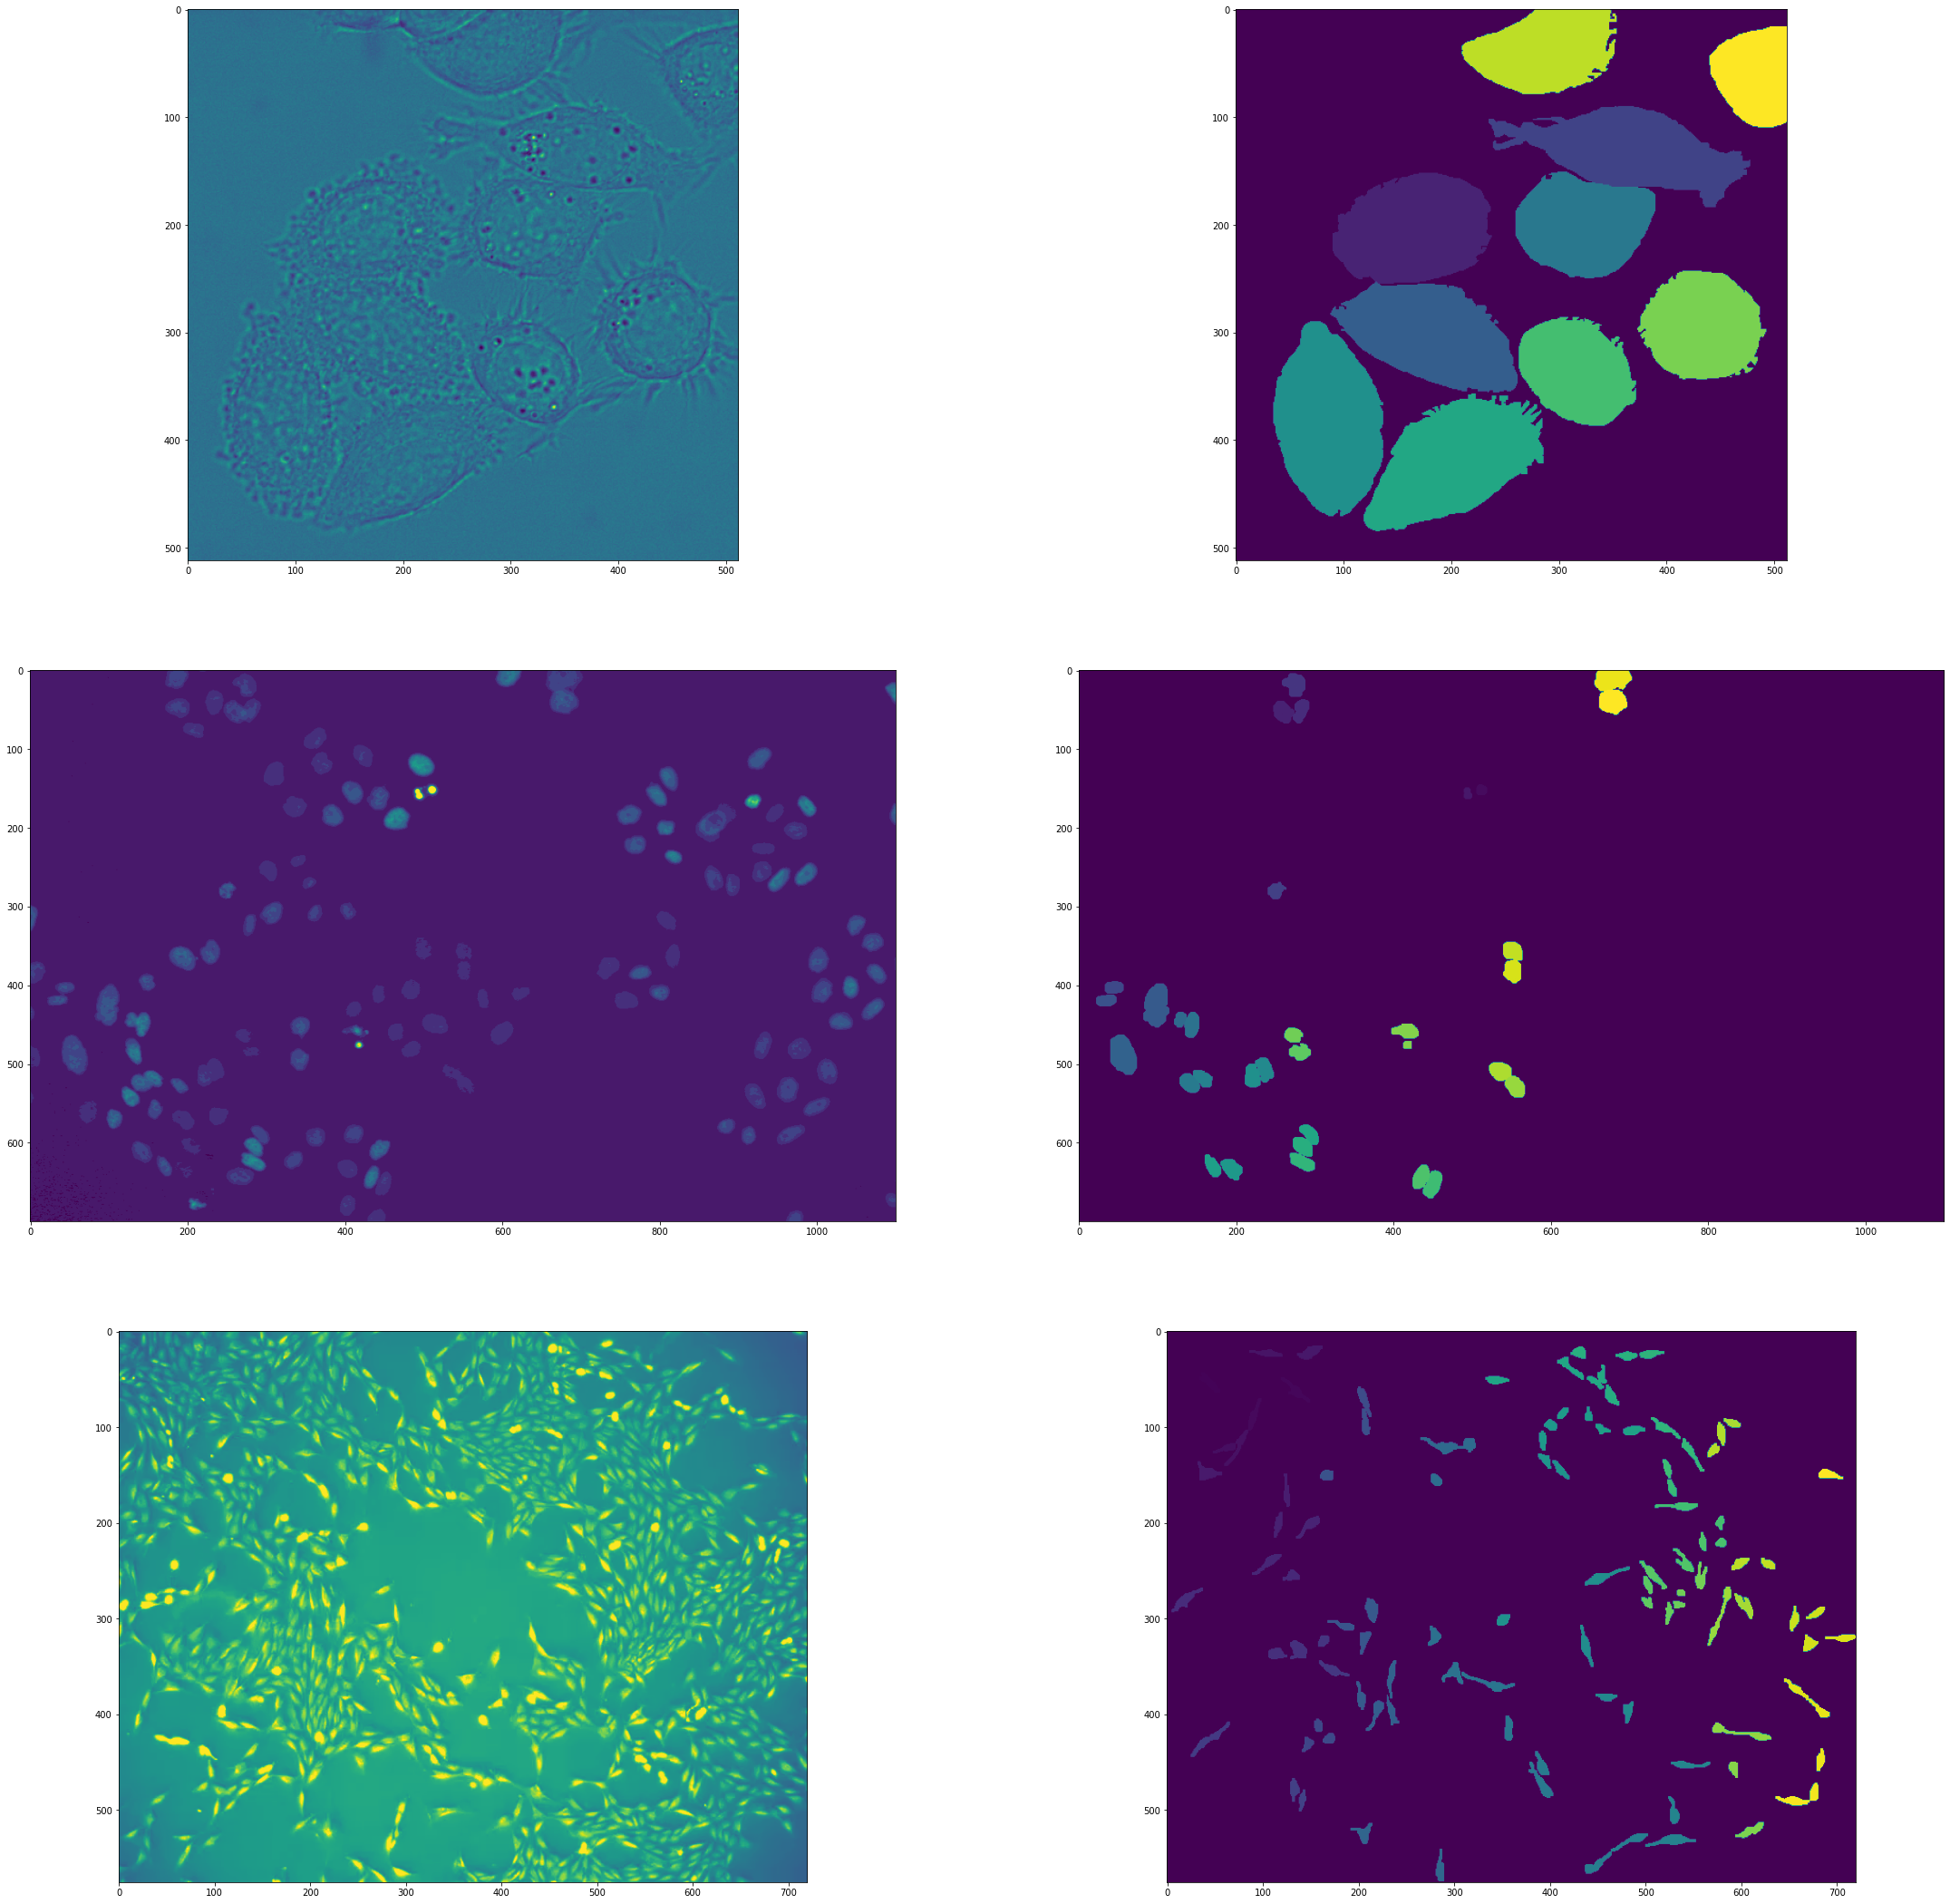

In [64]:
# import dataset path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os.path import join

dic_path = '/content/data/DIC-C2DH-HeLa'
fluo_path = '/content/data/Fluo-N2DL-HeLa/'
phc_path = '/content/data/PhC-C2DL-PSC/'

# test img display
f = plt.figure(figsize=(38, 38))
# dic
dic_test = cv2.imread(join(dic_path, 'Sequence 1/t002.tif'),0)
dic_testmask = cv2.imread(join(dic_path, 'Sequence 1 Masks/t002mask.tif'), -1)
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax1.imshow(dic_test)
ax2.imshow(dic_testmask)
# fluo
fluo_test = cv2.imread(join(fluo_path, 'Sequence 1/t088.tif'),0)
fluo_testmask = cv2.imread(join(fluo_path, 'Sequence 1 Masks/t088mask.tif'), cv2.IMREAD_ANYDEPTH)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax3.imshow(fluo_test)
ax4.imshow(fluo_testmask)
# phc
phc_test = cv2.imread(join(phc_path, 'Sequence 1/t350.tif'),0)
phc_testmask = cv2.imread(join(phc_path, 'Sequence 1 Masks/t098mask.tif'), -1)
ax5 = f.add_subplot(3,2,5)
ax6 = f.add_subplot(3,2,6)
ax5.imshow(phc_test)
ax6.imshow(phc_testmask)

/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


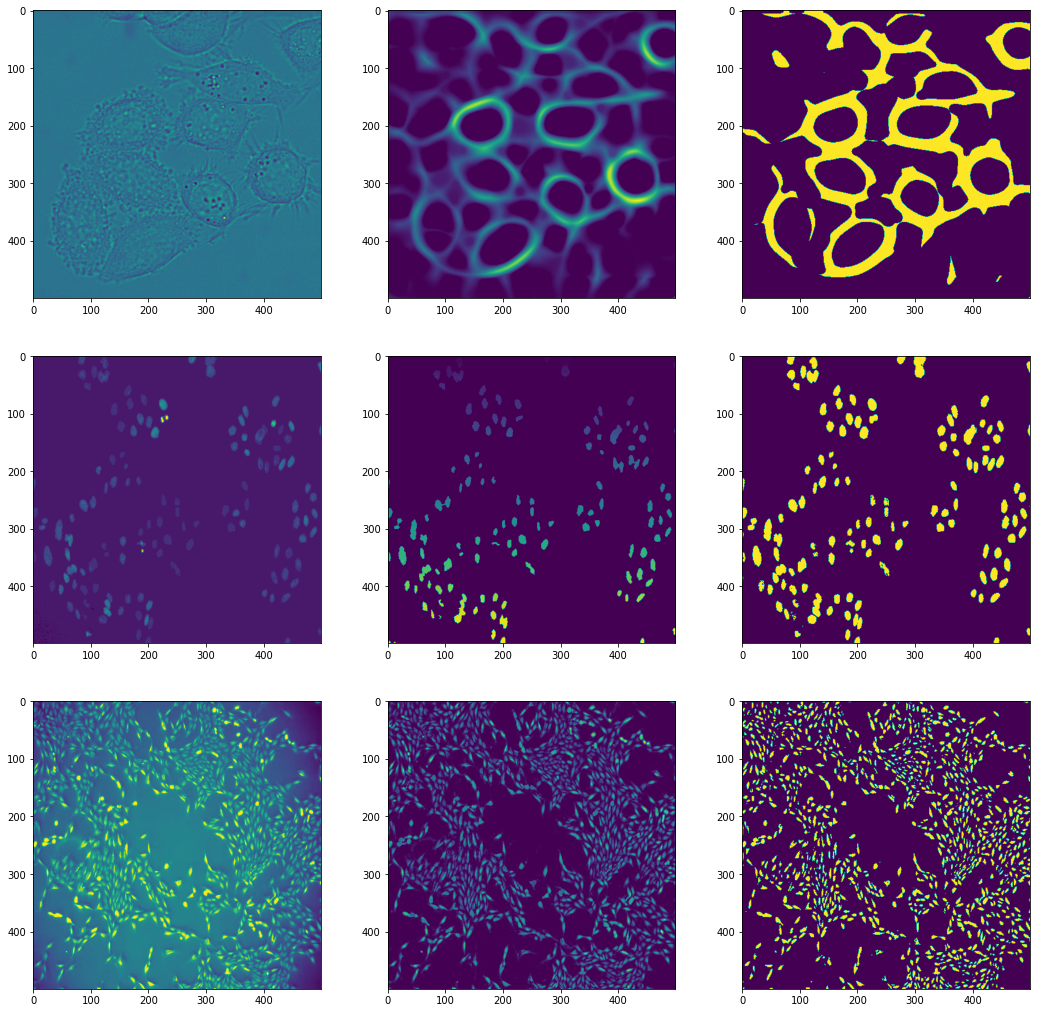

In [106]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import try_all_threshold, threshold_triangle, meijering, sato, frangi, hessian
from skimage import restoration
from skimage.feature import canny
from skimage import measure
from skimage.morphology import extrema

from skimage.morphology import reconstruction, disk, square, erosion
from skimage.filters import rank
from skimage import exposure
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage import data, color, img_as_ubyte

import random as rng

# Apply a Min-Max Filter
def full_min_max_filter(img, N):
    if N==-1:
        return img
    o = None
    b = cv2.dilate(cv2.erode(img, np.ones((N,N),np.uint8)), np.ones((N,N),np.uint8))
    o = img - b
    
    # clipping out-of-range value
    o[o < 0] = 0
    o[o > 255] = 255
    
    return o

# Apply a general interface for segmentation
# We have different segmentation method for each dataset. 
## option="dic" - TV Denoising + Sato + Ellipse Fitting
## option="fluo" - Illumination Adujust + Median Denoising + Otsu Thresholding + Watershed
## option="phc" - Illumination Adjust + MinMaxFilter + Otsu Thresholding
def thres_preprocessing(img, alpha, beta, minmax_N, morph_open, option, f = None, i = None):
    # return for invalid option
    if option not in ['dic','fluo','phc']:
        return None, None

    resized_img = cv2.resize(img, (500, 500))
    resized_copy = resized_img

    if option == 'fluo' or option == 'phc':
        distance = ndi.distance_transform_edt(resized_img)
        local_maxi = peak_local_max(distance, indices=True, labels=resized_img)
    resized_img = np.clip(alpha*resized_img + beta, 0, 255)

    # DIC segmentation
    if option=='dic':
        # median blur
        resized_img = rank.median(resized_img/255, disk(5))
        # denoise
        resized_img = restoration.denoise_tv_chambolle(resized_img, weight=10)
        # Histogram equalization
        resized_img = exposure.equalize_hist(resized_img)

        process = sato(resized_img, sigmas=[12])

        process = erosion(process, disk(5))

        p2, p98 = np.percentile(process, (2, 98))
        img_rescale = exposure.rescale_intensity(process, in_range=(p2, p98))
        img_rescale = (img_rescale*255).astype(np.uint8)

    # FLUO watershed segmentation
    if option=='fluo':
        # denoise image
        denoised = rank.median(resized_img / 255, disk(1))

        markers = rank.gradient(denoised, disk(1)) < 0.5
        markers = ndi.label(markers)[0]

        # local gradient (disk(2) is used to keep edges thin)
        gradient = rank.gradient(denoised, disk(2))

        # process the watershed
        process = watershed(gradient, markers)
        process = erosion(process, square(2))
    
    if option=='phc':
        # Apply Min-Max Filter if necessary
        resized_img = full_min_max_filter(resized_img, minmax_N)
        process = resized_img

    # Otsu's thresholding
    resized_img = resized_img.astype(np.uint8) # prepare for Otsu thresholding
    if option in ('fluo','phc'):
        _,th = cv2.threshold(resized_img,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU) 

        if option == 'fluo':
            th = ((process >= threshold_triangle(process)) * th + th > 0)

    else:
        _, th = cv2.threshold(img_rescale,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU) 

    """
    Debug-use img showing, need to include a figure of f
    # """
    if f != None and i != None:  
        ax = f.add_subplot(3,3,i)
        ax.imshow(resized_copy)
        ax0 = f.add_subplot(3,3,i+1)
        ax0.imshow(process)
        ax1 = f.add_subplot(3,3,i+2)
        ax1.imshow(th)

    return resized_img, th # return resized img, threshold type1, threshold type2


"""
A tester output of the above segmentation function.
Three images for each row. They represent:
1. The original image 
2. The middle-way processed image
    DIC: Result after applying Sato Ridger Operator
    FLUO: Watershed thresholding result
    PHC: Result after applying Min-Max Filter
3. Final thresholding output
"""
f2 = plt.figure(figsize=(18, 18))
dic_resized, dic_th = thres_preprocessing(dic_test, 1.7, 50, -1, 0, 'dic', f2, 1)
fluo_resized, fluo_th = thres_preprocessing(fluo_test, 1.1, 10, -1, 0, 'fluo', f2, 4)
phc_resized, phc_th = thres_preprocessing(phc_test, 1.3, 40, 7, 2, 'phc',f=f2, i=7)

### **Section 3. Cell Detection and Bounding Boxes**
Provide contour coordinates for cell detection. Also use the coordinates to provide bounding box details.

#### **Bounding Box Tools**
Give a set of functions that could be handy for quickly generating bounding boxes uniformly.

In [ ]:
def add_boundingbox(path, img, ls): # overwrite the file at the path with the bounding-boxed img
    label_img = label(ls)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)

    for region in regionprops(label_img):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig(path)
        
def add_boundingbox_for_all(src, dest, iteration = 250, # operational arguments for level-set parameter tuning
                                     initial_ls_type='default', 
                                     level_size=4):
    if not path.exists(dest):
        destination = shutil.copytree(src, dest, copy_function = shutil.copy)

    # count how many images to process
    count = 0
    for (dirpath, dirnames, filenames) in os.walk(dest):
        for file in filenames:
            file_type = (dirpath.split('/')[-1]).split(' ')[-1]
            if file_type == 'Masks':  # skip labels
                continue
            count += 1
    
    # do the boundings in the dest repo
    progress = ProgressBar()
    i = 0
    progress.update_progress(0)
    for (dirpath, dirnames, filenames) in os.walk(dest):
        for file in filenames:
            file_type = (dirpath.split('/')[-1]).split(' ')[-1]
            if file_type == 'Masks':  # skip labels
                continue
            # load the img
            img = cv2.imread(path.join(dirpath, file),0)
            # do img preprocessing
            resized_img, thres, thres2 = thres_preprocessing(img)
            # get the segmentation
            # The first output is the final segmentation result
            # The second output contains all history segmentation results during 
            # the level-set converging procedure
            ls, _ = level_set_segmentation(thres, iteration = iteration,
                                                level_set=initial_ls_type, 
                                                level_size=level_size)
            # get the bounding-boxes
            add_boundingbox(path.join(dirpath, file), resized_img, ls)

            # progress bar
            i += 1
            progress.update_progress(i/count)

#### **Method-1: Use Level-Set Method.**
Provide good segmentation for simple cell images, but could not deal with heavily-clustered cells very well.

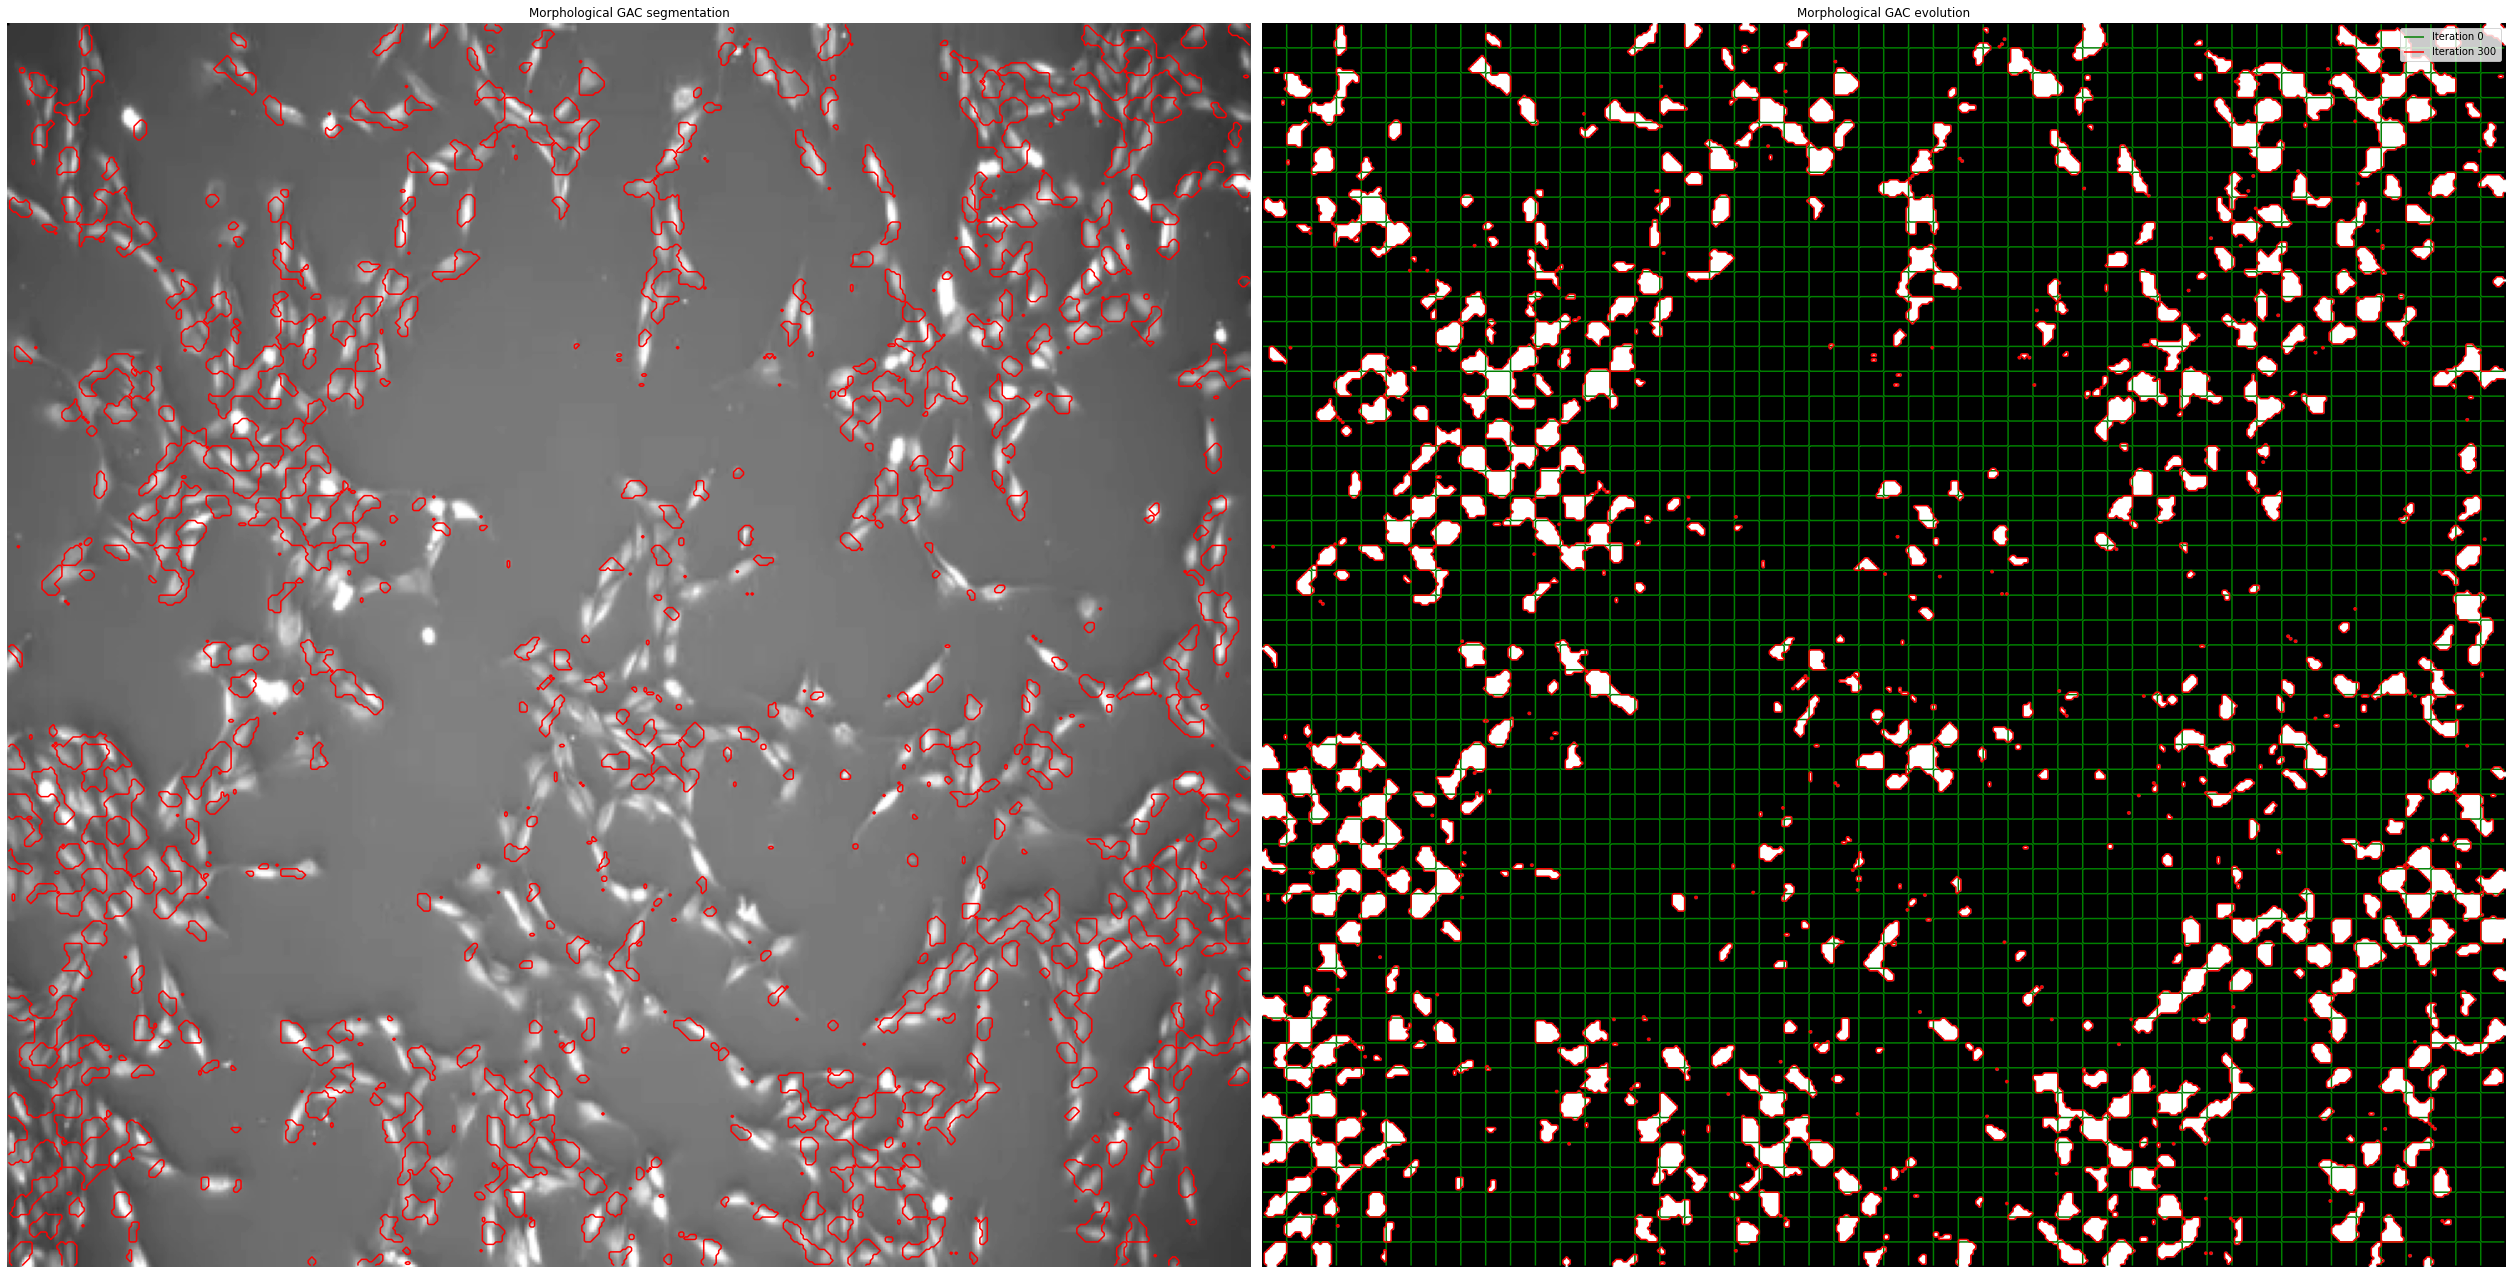

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,circle_level_set,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

def initial_circle_ls(shape, level_size):
    circles_ls = np.zeros(shape)
    x, y = shape
    for i in range(level_size):
        for j in range(level_size):
            cls = circle_level_set(shape, 
                                   (int(x/(level_size*2) + i* (x/level_size)), 
                                    int(y/(level_size*2) + j* (y/level_size))), 
                                   int(x/(level_size*2)))
            circles_ls += cls
    return circles_ls
    
def level_set_segmentation(img, iteration = 300,
                                level_set='default', 
                                level_size=4):
    # get gradients
    gimg = inverse_gaussian_gradient(img, alpha=1.0, sigma=1.0)

    init_ls = None
    # decide level set type
    if level_set == 'default':
        init_ls = np.zeros(img.shape, dtype=np.int8)
        init_ls[5:-5, 5:-5] = 1
    elif level_set == 'checkerboard':
        init_ls = checkerboard_level_set(img.shape, level_size)
        reverse_ls = checkerboard_level_set
    elif level_set == 'circles':
        init_ls = initial_circle_ls(img.shape, level_size)
    
    # List with intermediate results for plotting the evolution
    evolution = []
    callback = store_evolution_in(evolution)
    ls = morphological_geodesic_active_contour(gimg, iteration, init_ls,
                                               smoothing=1, balloon=-1,
                                               threshold=0.8,
                                               iter_callback=callback)
    
    return ls, evolution

# test 
img2 = cv2.resize(phc_test, (500, 500))
img = cv2.resize(phc_th, (500, 500))
ls, evolution = level_set_segmentation(img, 250, 'checkerboard', 10)

fig, axes = plt.subplots(1, 2, figsize=(35, 35))
ax = axes.flatten()
ax[0].imshow(img2, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological GAC segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 300")
ax[1].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[1].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()

#### **Method-2: Use Marching Squares Algorithm**
Generally could handle with most types of the cell images. Notice that the function now directly stores the cell detection results (i.e. the coordinates of the bounding boxes) into a numpy file at a given path.

In [104]:
from skimage.measure import label, regionprops,find_contours
import matplotlib.patches as mpatches
import os.path as path
import shutil
import os
from progress_bar import ProgressBar
from numpy import save
import math

def label_contours(src, dest, alpha, beta, minmax_N, morph_open, dataset_type, noise_level=3):
    if not path.exists(dest):
        destination = shutil.copytree(src, dest, copy_function = shutil.copy)

    # count how many images to process
    count = 0
    for (dirpath, dirnames, filenames) in os.walk(dest):
        for file in filenames:
            file_type = (dirpath.split('/')[-1]).split(' ')[-1]
            if file_type == 'Masks':  # skip labels
                continue
            count += 1
    
    # do the boundings in the dest repo
    progress = ProgressBar() # visualising tool used to show the on-going progress of all image segmentations
    i = 0
    progress.update_progress(0)
    for (dirpath, dirnames, filenames) in os.walk(dest):
        for file in filenames:
            file_type = (dirpath.split('/')[-1]).split(' ')[-1]
            if file_type == 'Masks':  # skip labels
                continue
            # load the img
            img = cv2.imread(path.join(dirpath, file),0)
            # do img preprocessing
            resized_img, thres = thres_preprocessing(img, alpha, beta, minmax_N, morph_open, dataset_type)
            # get the contours using library built-in Marching Square Algorithm
            if dataset_type == 'dic':
                contours, _= cv2.findContours(thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            else:
                contours = find_contours(thres, 0.5)
            # stor coordinate results
            store_contours(contours, path.join(dirpath, file), resized_img, dataset_type, noise_level)
            # record progress
            progress.update_progress((i+1)/count)
            # proceed progress bar
            i += 1

def store_contours(contours, dest, img, data_type, noise_level):
    results = []
    i = 0

    if data_type == 'dic':
        # Find the rotated rectangles and ellipses for each contour
        minRect = [None]*len(contours)
        minEllipse = [None]*len(contours)
        # Add extra auxiliary processing for ellipse fitting
        for m, c in enumerate(contours):
            minRect[m] = cv2.minAreaRect(c)
            if c.shape[0] > 5:
                minEllipse[m] = cv2.fitEllipse(c)
        for m, c in enumerate(contours):
            color = (255, 0, 0)
            if c.shape[0] > 5:
                H = minEllipse[m][1][0]
                W = minEllipse[m][1][1]
                ellipse_area = math.pi * (H/2.0) * (W/2.0)
                # remove potential fake ellipse (which does not represent a cell unit)
                if ellipse_area > 0 and cv2.contourArea(c)/ellipse_area > 0.8 and ellipse_area > 1500 and ellipse_area < 30000:
                    # rotated rectangle
                    box = cv2.boxPoints(minRect[m])
                    x1 = np.min(box[:,0]).astype(np.int)
                    x2 = np.max(box[:,0]).astype(np.int)
                    y1 = np.min(box[:,1]).astype(np.int)
                    y2 = np.max(box[:,1]).astype(np.int)
                    cropped_img = img[x1:x2,y1:y2]
                    if x2-x1 < noise_level or y2-y1 < noise_level: 
                        continue
                    results.append((i, cropped_img, x1, x2, y1, y2))
                    i += 1
    else:
        # directly store the bounding box coordinates
        for contour in contours:
            x1 = np.min(contour[:,0]).astype(np.int)
            x2 = np.max(contour[:,0]).astype(np.int)
            y1 = np.min(contour[:,1]).astype(np.int)
            y2 = np.max(contour[:,1]).astype(np.int)
            if x2-x1 < noise_level or y2-y1 < noise_level: 
                continue
            label = i
            cropped_img = img[x1:x2,y1:y2]
            results.append((label, cropped_img, x1, x2, y1, y2))
            i += 1
    results = np.array(results)
    # save
    store_path = dest.split('.')[0]+'.npy'
    save(store_path, results)

# test running
# dic
label_contours('/content/dic_test/', '/content/test/',1.7, 50, -1, 0, 'dic')
# fluo
label_contours('/content/fluo_test/', '/content/test2/',1.1, 10, -1, 0, 'fluo')
# phc
label_contours('/content/phc_test/', '/content/test3/',1.3, 40, 7, 2, 'phc')


Progress: [####################] 100.0%


#### **Further usage:**
The detected results are saved as local numpy files. The main box-bounding, tracking and motion analysis is undertaken in another notebook edited by Shizuka. In that notebook, it calls the numpy data generated in this notebook and carries out the whole tracking process.

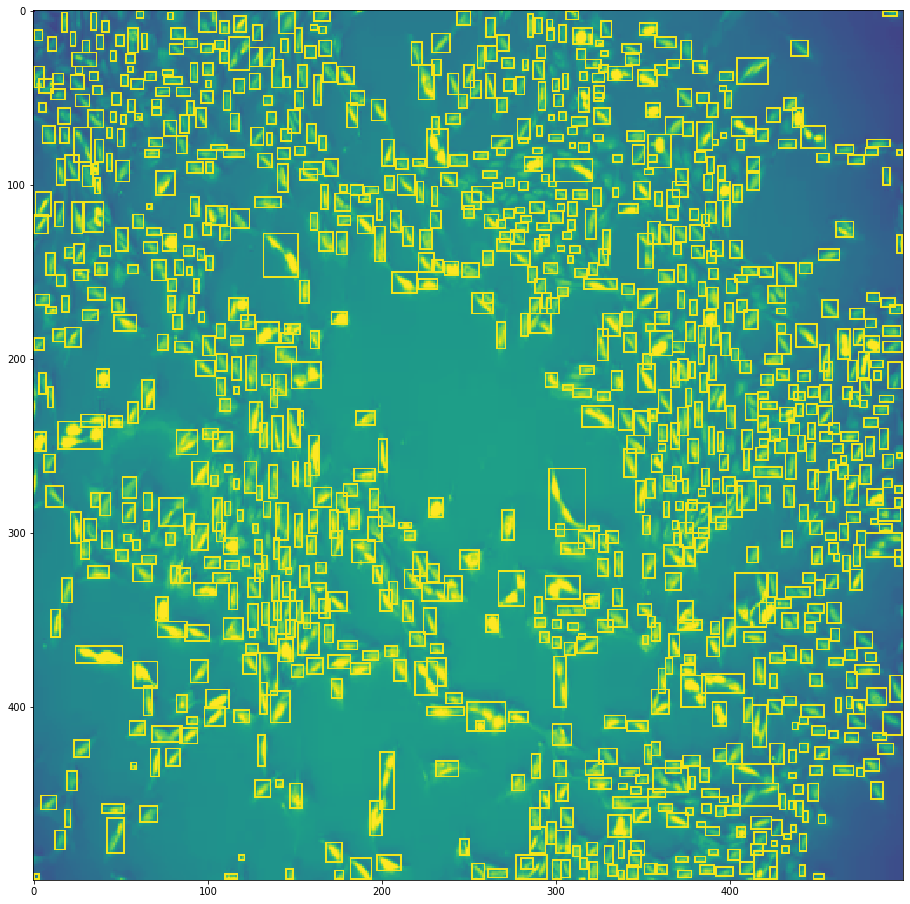

In [105]:
# A quick test on whether the saved numpy could be re-loaded to bounding boxes and used
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon_perimeter
from numpy import load

for i in range(1):
    test = load('/content/test3/t350.npy'.format(i),allow_pickle=True)
    img = cv2.imread('/content/test3/t350.tif'.format(i),0)

    with_boxes  = np.copy(cv2.resize(img, (500, 500)))
    plt.figure(figsize=(16, 16))

    for each in test:
        a, b, c, d, e, f = each
        # print(a)
        #[Xmin, Xmax, Ymin, Ymax]
        r1 = [c,d,d,c, c]
        c1 = [e,e,f,f, e]
        rr, cc = polygon_perimeter(r1, c1, with_boxes.shape)
        with_boxes[rr, cc] = 250 # set a suitable color to see the bounding boxes
    plt.imshow(with_boxes, interpolation='nearest')
    plt.show()